# Treeflow example - carnivores data

Dataset from **Suchard, Marc A., and Andrew Rambaut. "Many-core algorithms for statistical phylogenetics." *Bioinformatics* 25.11 (2009): 1370-1376.**

Sequences accessed from [Beast examples on Github](https://github.com/beast-dev/beast-mcmc/blob/v1.10.4/examples/Benchmarks/benchmark2.xml).

In [1]:
import treeflow

2022-05-31 23:12:30.895170: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-31 23:12:30.895186: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Read input data

In [2]:
tree = treeflow.convert_tree_to_tensor(treeflow.parse_newick("demo-data/carnivores.newick"))
tree.taxon_set

2022-05-31 23:12:32.839305: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-31 23:12:32.839538: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-31 23:12:32.839555: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (CS424460): /proc/driver/nvidia/version does not exist
2022-05-31 23:12:32.840498: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


('Puma_concolor_',
 'Acinonyx_jubatus_',
 'Lynx_canadensis_',
 'Felis_silvestris_',
 'Uncia_uncia_',
 'Panthera_pardus_',
 'Panthera_tigris_',
 'Neofelis_nebulosa_',
 'Herpestes_auropunctatus_',
 'Leptonychotes_weddellii_',
 'Hydrurga_leptonyx_',
 'Ommatophoca_rossii_',
 'Lobodon_carcinophaga_',
 'Mirounga_leonina_',
 'Mirounga_angustirostris_',
 'Monachus_monachus_',
 'Monachus_schauinslandi_',
 'Phoca_fasciata_',
 'Phoca_groenlandica_',
 'Phoca_caspica_',
 'Halichoerus_grypus_',
 'Phoca_sibirica_',
 'Phoca_largha_',
 'Phoca_vitulina_',
 'Phoca_hispida_',
 'Cystophora_cristata_',
 'Erignathus_barbatus_',
 'Arctocephalus_forsteri_',
 'Arctocephalus_australis_',
 'Arctocephalus_townsendi_',
 'Neophoca_cinerea_',
 'Phocarctos_hookeri_',
 'Arctocephalus_pusillus_',
 'Otaria_byronia_',
 'Zalophus_californianus_',
 'Eumetopias_jubatus_',
 'Callorhinus_ursinus_',
 'Odobenus_rosmarus_',
 'Enhydra_lutris_',
 'Lontra_canadensis_',
 'Mustela_vison_',
 'Martes_melampus_',
 'Martes_americana_',
 '

In [3]:
alignment = treeflow.Alignment("demo-data/carnivores.fasta").get_compressed_alignment()
alignment

WeightedAlignment(taxon_count=62, pattern_count=5565)

Calibrations from **Hassanin, Alexandre, et al. "Evolutionary history of Carnivora (Mammalia, Laurasiatheria) inferred from mitochondrial genomes." *PloS one* 16.2 (2021): e0240770.**

In [4]:
import yaml
with open("demo-data/carnivore-calibrations.yaml") as f:
    calibration_dict = yaml.safe_load(f)
    
calibration_set = treeflow.MRCACalibrationSet(calibration_dict)
calibration_set

MRCACalibrationSet(MRCACalibration(name='Guloninae, Mustilinae', range=(12.2, 27.6)), MRCACalibration(name='Felidae', range=(14, 20)), MRCACalibration(name='Pinnipedia', range=(19, 34)))

## Model specification

### Single kappa parameter across tree

In [5]:
import tensorflow as tf
import tensorflow_probability as tfp
from treeflow import float_constant as c
from treeflow.evolution.substitution import HKY, get_transition_probabilities_tree
from treeflow.distributions import DiscretizedDistribution, DiscreteParameterMixture, LeafCTMC, SampleWeighted


site_category_count = 4
pattern_counts = alignment.get_weights_tensor()
subst_model = HKY()

def build_sequence_dist(tree, kappa, frequencies, site_gamma_shape):
    unrooted_tree = tree.get_unrooted_tree()
    site_rate_distribution = DiscretizedDistribution(
        category_count=site_category_count,
        distribution=tfp.distributions.Gamma(concentration=site_gamma_shape, rate=site_gamma_shape),
    )
    transition_probs_tree = get_transition_probabilities_tree(
        unrooted_tree,
        subst_model,
        rate_categories=site_rate_distribution.support,
        frequencies=frequencies,
        kappa=kappa
    )
    return SampleWeighted(
        DiscreteParameterMixture(
            site_rate_distribution,
            LeafCTMC(
                transition_probs_tree,
                tf.expand_dims(frequencies, -2),
            ),
        ),
        sample_shape=alignment.site_count,
        weights=pattern_counts
    )
    

base_model = tfp.distributions.JointDistributionNamed(dict(
    birth_rate=tfp.distributions.LogNormal(c(1.0), c(1.5)),
    tree=lambda birth_rate: treeflow.distributions.Yule(tree.taxon_count, birth_rate, name="tree"),
    kappa=tfp.distributions.LogNormal(c(0.0), c(2.0)),
    site_gamma_shape=tfp.distributions.LogNormal(c(0.0), c(1.0)),
    frequencies=tfp.distributions.Dirichlet(c([2.0, 2.0, 2.0, 2.0])),
    sequences=build_sequence_dist
))
base_model_pinned = base_model.experimental_pin(sequences=alignment.get_encoded_sequence_tensor(tree.taxon_set))
prior_samples = base_model_pinned.sample_unpinned()
prior_samples.keys()

/home/cswa648/dev/treeflow/treeflow/distributions/tree/birthdeath/birth_death_contemporary_sampling.py:69: UserWarning: Dummy sampling
  warnings.warn("Dummy sampling")
/home/cswa648/dev/treeflow/treeflow/tf_util/attrs.py:7: UserWarning: Temporary hotfix
  warnings.warn("Temporary hotfix")


/home/cswa648/dev/treeflow/treeflow/distributions/leaf_ctmc.py:62: UserWarning: Dummy sampling of alignment
  warnings.warn("Dummy sampling of alignment")


dict_keys(['birth_rate', 'tree', 'site_gamma_shape', 'kappa', 'frequencies'])

Instructions for updating:
Do not call `graph_parents`.


/home/cswa648/dev/treeflow/treeflow/tf_util/attrs.py:7: UserWarning: Temporary hotfix
  warnings.warn("Temporary hotfix")


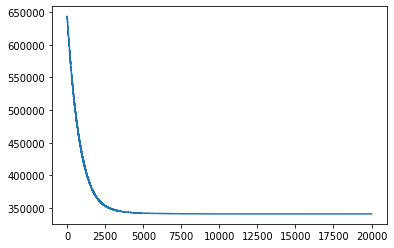

In [6]:
from treeflow.vi import fit_fixed_topology_variational_approximation
import matplotlib.pyplot as plt

optimizer = tf.optimizers.Adam()
num_steps= 20000
base_approx, base_loss = fit_fixed_topology_variational_approximation(
    base_model_pinned,
    topologies=dict(tree=tree.topology),
    optimizer=optimizer,
    num_steps=num_steps,
    trace_fn= lambda x: x.loss
)
plt.plot(base_loss)

/home/cswa648/dev/treeflow/treeflow/tf_util/attrs.py:7: UserWarning: Temporary hotfix
  warnings.warn("Temporary hotfix")
/home/cswa648/dev/treeflow/treeflow/distributions/tree/birthdeath/birth_death_contemporary_sampling.py:69: UserWarning: Dummy sampling
  warnings.warn("Dummy sampling")


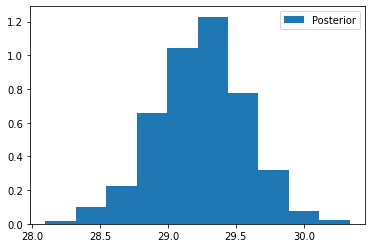

In [7]:
n_samples = 1000
base_samples = base_approx.sample(n_samples)
prior_samples = base_model_pinned.sample_unpinned(n_samples)

plt.hist(base_samples["kappa"].numpy(), label="Posterior", density=True)
plt.legend()

(array([  8.,  40., 114., 191., 244., 230., 114.,  44.,  12.,   3.]),
 array([1.16489095, 1.16955259, 1.17421422, 1.17887585, 1.18353749,
        1.18819912, 1.19286075, 1.19752239, 1.20218402, 1.20684565,
        1.21150729]),
 <BarContainer object of 10 artists>)

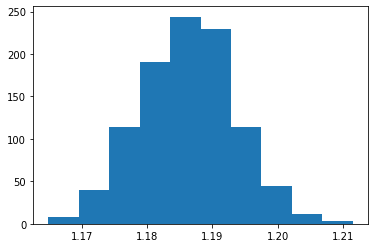

In [8]:
plt.hist(base_samples["tree"].node_heights[:, -1].numpy())

In [21]:
from treeflow.tree.io import write_tensor_trees
from treeflow.model.io import write_samples_to_file

base_out_samples = dict(base_samples)
base_tree_samples = base_out_samples.pop("tree")
write_tensor_trees(
    "demo-data/carnivores.newick", base_tree_samples.branch_lengths, "demo-out/carnivores-base-trees.nexus"
)
write_samples_to_file(
    base_samples, base_model_pinned, "demo-out/carnivores-base-samples.csv", vars=base_out_samples.keys()
)

### Per site kappa parameter

In [9]:
def build_sequence_dist_alt(tree, kappa, frequencies, site_gamma_shape):
    # kappa has shape (..., n_branches)
    unrooted_tree = tree.get_unrooted_tree()
    site_rate_distribution = DiscretizedDistribution(
        category_count=site_category_count,
        distribution=tfp.distributions.Gamma(concentration=site_gamma_shape, rate=site_gamma_shape),
    )
    frequencies_b = tf.broadcast_to(tf.expand_dims(frequencies, -2), kappa.shape + (4,))
    transition_probs_tree = get_transition_probabilities_tree(
        unrooted_tree,
        subst_model,
        rate_categories=site_rate_distribution.support,
        frequencies=frequencies_b,
        kappa=kappa,
        inner_batch_rank=1,
        batch_rank=-1 # Don't add a batch dimension for branches
    )
    return SampleWeighted(
        DiscreteParameterMixture(
            site_rate_distribution,
            LeafCTMC(
                transition_probs_tree,
                tf.expand_dims(frequencies, -2),
            ),
        ),
        sample_shape=alignment.site_count,
        weights=pattern_counts
    )
alt_model = tfp.distributions.JointDistributionNamed(dict(
    birth_rate=tfp.distributions.LogNormal(c(1.0), c(1.5)),
    tree=lambda birth_rate: treeflow.distributions.Yule(tree.taxon_count, birth_rate, name="tree"),
    kappa=tfp.distributions.Sample(tfp.distributions.LogNormal(c(0.0), c(2.0)), tree.branch_lengths.shape),
    site_gamma_shape=tfp.distributions.LogNormal(c(0.0), c(1.0)),
    frequencies=tfp.distributions.Dirichlet(c([2.0, 2.0, 2.0, 2.0])),
    sequences=build_sequence_dist_alt
))
alt_model_pinned = alt_model.experimental_pin(sequences=alignment.get_encoded_sequence_tensor(tree.taxon_set))
prior_samples = alt_model_pinned.sample_unpinned()
prior_samples.keys()

/home/cswa648/dev/treeflow/treeflow/distributions/leaf_ctmc.py:62: UserWarning: Dummy sampling of alignment
  warnings.warn("Dummy sampling of alignment")


dict_keys(['birth_rate', 'tree', 'site_gamma_shape', 'kappa', 'frequencies'])

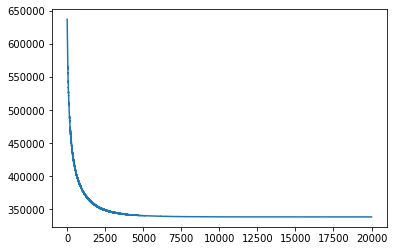

In [10]:
alt_approx, alt_loss = fit_fixed_topology_variational_approximation(
    alt_model_pinned,
    topologies=dict(tree=tree.topology),
    optimizer=optimizer,
    num_steps=num_steps,
    trace_fn= lambda x: x.loss
)
plt.plot(alt_loss)

/home/cswa648/dev/treeflow/treeflow/tf_util/attrs.py:7: UserWarning: Temporary hotfix
  warnings.warn("Temporary hotfix")


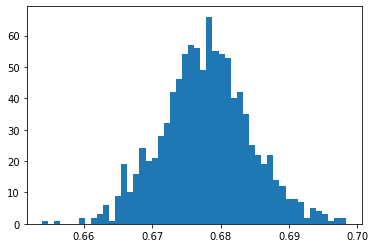

In [11]:
alt_samples = alt_approx.sample(n_samples)
plt.hist(alt_samples["tree"].node_heights[:, -1].numpy(), bins=50);

In [22]:
alt_out_samples = dict(alt_samples)
alt_tree_samples = alt_out_samples.pop("tree")
write_tensor_trees(
    "demo-data/carnivores.newick",
    alt_tree_samples.branch_lengths,
    "demo-out/carnivores-alt-trees.nexus",
    branch_metadata=dict(kappa=alt_out_samples["kappa"])
)
write_samples_to_file(
    alt_samples, alt_model_pinned, "demo-out/carnivores-alt-samples.csv", vars=alt_out_samples.keys()
)

In [23]:
from importlib import reload
import treeflow.vi
reload(treeflow.vi)

<module 'treeflow.vi' from '/home/cswa648/dev/treeflow/treeflow/vi/__init__.py'>

In [24]:
[tf.reduce_mean(x[-100:]) for x in [base_loss, alt_loss]]

[<tf.Tensor: shape=(), dtype=float64, numpy=341177.1346313156>,
 <tf.Tensor: shape=(), dtype=float64, numpy=338657.6796321058>]

In [33]:
tf.nest.map_structure(lambda x: x.shape, base_samples)

{'birth_rate': TensorShape([1000]),
 'tree': TensorflowRootedTree(node_heights=TensorShape([1000, 61]), sampling_times=TensorShape([62]), topology=TensorflowTreeTopology(parent_indices=TensorShape([122]), child_indices=TensorShape([123, 2]), preorder_indices=TensorShape([123]))),
 'site_gamma_shape': TensorShape([1000]),
 'kappa': TensorShape([1000]),
 'frequencies': TensorShape([1000, 4])}

In [ ]:
from treeflow.vi import estimate_log_ml_importance_sampling

base_ml_result = estimate_ml_importance_sampling(base_model_pinned, base_approx)
alt_ml_result = estimate_ml_importance_sampling(alt_model_pinned, alt_approx)

dict(
    base=base_ml_result.numpy(),
    lineage_variation=alt_ml_result.numpy()
)

2022-06-01 09:26:39.302207: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 4416384000 exceeds 10% of free system memory.


In [ ]:
import joypy
import numpy as np
import pandas as pd

kappa_df = pd.DataFrame(alt_samples["kappa"].numpy())
n_columns = 10
columns = np.random.choice(kappa_df.columns, n_columns, replace=False)
joypy.joyplot(kappa_df[columns]);

## Results visualisation


* Use existing tree viz tools